# Linearity of the VAS model equations
In this notebook I look at the model equations and asses wheter or not the equations are linear.

In [1]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# import the needed OGGM modules
import oggm
from oggm import cfg, utils, graphics
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, inversion, flowline, vascaling

In [2]:
# specify the RGI ID for Hintereisferner
rgi_id = 'RGI60-11.00897'
rgi_region = (rgi_id.split('-')[-1]).split('.')[0]
rgi_version = (rgi_id.split('-')[0])[-2:]

## Preprocessing

In [3]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 10
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-07-31 10:59:22: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


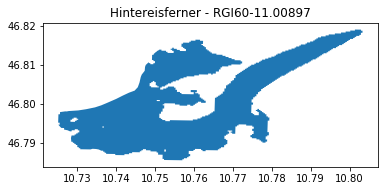

In [4]:
# read RGI entry for Hintereisferner as DataFrame
# containing the outline area as shapefile
entity = utils.get_rgi_glacier_entities([rgi_id])
# quick look, to make sure we got the rigth one
entity.plot()
plt.title('Hintereisferner - ' + rgi_id)
# select the row containing HEF from DataFrame
entity = entity.iloc[0]

In [5]:
# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

In [6]:
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, reset=True)

In [7]:
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

2019-07-31 10:59:23: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-07-31 10:59:23: oggm.core.gis: (RGI60-11.00897) glacier_masks


In [8]:
# process the given climate file
climate.process_histalp_data(gdir)

2019-07-31 10:59:24: oggm.core.climate: (RGI60-11.00897) process_histalp_data


## Mass balance model

In [94]:
# instance past mass balance model
past_mb_mod = vascaling.VAScalingMassBalance(gdir)
# get equilibrium year t*
tstar = gdir.read_json('vascaling_mustar')['t_star']
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# create empty container
past_mb = list()
years = np.arange(tstar - cfg.PARAMS['mu_star_halfperiod'],
                  tstar + cfg.PARAMS['mu_star_halfperiod'] + 1)

for yr in years:
    mb_yr = past_mb_mod.get_specific_mb(min_hgt, max_hgt, yr)
    past_mb.append(mb_yr)
    
# convert into pd.DataFrame
past_mb = pd.DataFrame(past_mb, index = years.astype(int), columns=['spec_mb'])

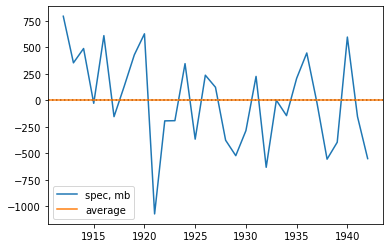

In [228]:
plt.plot(past_mb, label='spec, mb')
plt.axhline(0, c='k', ls=':')
plt.axhline(np.average(past_mb), label='average', c='C1')
plt.legend()

In [229]:
# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)
tstar = gdir.read_json('vascaling_mustar')['t_star']
# use t* = 1927, coherent with eq runs
tstar = 1927
vascaling.local_t_star(gdir, tstar=tstar, bias=0)

# instance the mass balance models
temp_bias = 0.5
eq_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
pos_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
pos_mb_mod.temp_bias = -temp_bias
neg_mb_mod = vascaling.ConstantVASMassBalance(gdir, y0=tstar, bias=0)
neg_mb_mod.temp_bias = +temp_bias

2019-07-31 12:54:35: oggm.core.vascaling: (RGI60-11.00897) local_t_star
2019-07-31 12:54:36: oggm.core.vascaling: (RGI60-11.00897) local_t_star


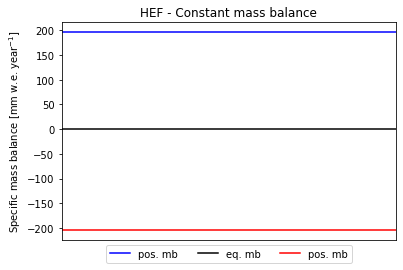

In [230]:
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
# compute mass balance
pos_mb = pos_mb_mod.get_specific_mb(min_hgt, max_hgt, year=1)
eq_mb = eq_mb_mod.get_specific_mb(min_hgt, max_hgt, year=1)
neg_mb = neg_mb_mod.get_specific_mb(min_hgt, max_hgt, year=1)
# visualize
plt.axhline(pos_mb, c='b', label='pos. mb')
plt.axhline(eq_mb, c='k', label='eq. mb')
plt.axhline(neg_mb, c='r', label='pos. mb')
plt.legend(ncol=3, bbox_to_anchor=(0.5, 0), loc='upper center')
plt.title('HEF - Constant mass balance')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.xticks([]);

In [236]:
model = vascaling.VAScalingModel(0, gdir.rgi_area_m2, min_hgt, max_hgt, eq_mb_mod)
ds_eq = model.run_until_and_store(100)
model = vascaling.VAScalingModel(0, gdir.rgi_area_m2, min_hgt, max_hgt, pos_mb_mod)
ds_pos = model.run_until_and_store(100)
model = vascaling.VAScalingModel(0, gdir.rgi_area_m2, min_hgt, max_hgt, neg_mb_mod)
ds_neg = model.run_until_and_store(100)

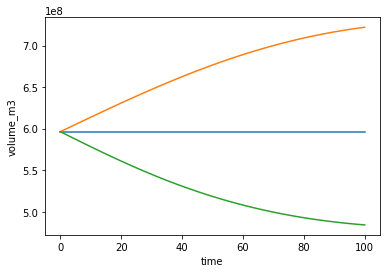

In [237]:
ds_eq.volume_m3.plot()
ds_pos.volume_m3.plot()
ds_neg.volume_m3.plot()

In [337]:
# define range of temp biases
temp_bias = np.arange(-50, 50.1, 0.1)
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=temp_bias, columns=['spec_mb'])

Text(0, 0.5, 'Specific mass balance [mm w.e. year$^{-1}$]')

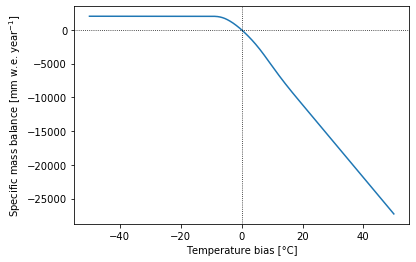

In [338]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

ax.plot(const_mb)
# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Temperature bias [°C]')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')

Compute linear approximation near 0°C temperature bias...

In [339]:
from sklearn import linear_model

x = const_mb.loc[(temp_bias >= 20)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9999999999699711
intercept: [-313.47782632]
slope: [[-539.08952389]]


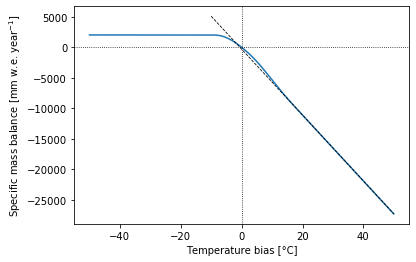

In [340]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

ax.plot(const_mb)
# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Temperature bias [°C]')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')

# plot linear regression
x = const_mb.loc[-10:].index.values
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax.plot(x, y, ls='--', c='k', lw=0.8)

In [345]:
# define range of temp biases
temp_bias = np.arange(-10, 10.1, 0.1)
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in temp_bias:
    # add temperature bias
    const_mb_mod.temp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=temp_bias, columns=['spec_mb'])

In [346]:
from sklearn import linear_model

bias_limit = 1
x = const_mb.loc[(temp_bias >= -(bias_limit+0.01)) & (temp_bias <= bias_limit)]
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9995220649376573
intercept: [-5.89756071]
slope: [[-400.14623192]]


Text(0.5, 1.0, 'Difference between mass balance an linear regression')

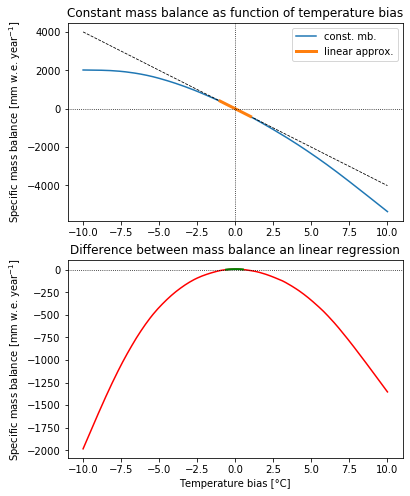

In [356]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])

# plot mass balance
ax0.plot(const_mb, label='const. mb.')
# plot linear regression
x = temp_bias
y = x * lin_mod.coef_[0] + lin_mod.intercept_
ax0.plot(x, y, ls='--', c='k', lw=0.8)
ax0.plot(x[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         y[(x >= -(bias_limit+0.01)) & (x <= bias_limit)],
         ls='-', c='C1', lw=3, label='linear approx.')

# add aux lines
ax0.axhline(0, c='k', ls=':', lw=0.8)
ax0.axvline(0, c='k', ls=':', lw=0.8)

# labels, title, ...
ax0.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax0.set_title('Constant mass balance as function of temperature bias')
ax0.legend()

# compute and plot differences in spec mb
dif = const_mb.values.flatten() - y
ax1.plot(x, dif, c='r')
ax1.plot(x[dif >= 0], dif[dif >= 0], c='g', lw=2)
ax1.axhline(0, c='k', ls=':', lw=0.8)
ax1.set_xlabel('Temperature bias [°C]')
ax1.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
ax1.set_title('Difference between mass balance an linear regression')

The constant mass balance can be approximate by a linear function for temperature biases between -1°C and 1°C, with a coefficient of determination of 0.9995.

Take a quick look at the precipiation bias...

In [320]:
# define range of temp biases
prcp_bias = np.unique(np.sort(np.concatenate([1/np.arange(1,10+1), np.arange(1,10+1)])))
# create empty container
const_mb = list()
# get minimal and maximal glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# instance mass balance model
const_mb_mod = vascaling.ConstantVASMassBalance(gdir, bias=0)

# iterate over all temperature biases
for b in prcp_bias:
    # add temperature bias
    const_mb_mod.prcp_bias = b
    # compute mass balance and add to list
    const_mb.append(const_mb_mod.get_specific_mb(min_hgt, max_hgt, year=0))
    
# convert into DataFrame
const_mb = pd.DataFrame(const_mb, index=prcp_bias, columns=['spec_mb'])

In [323]:
from sklearn import linear_model

bias_limit = None
x = const_mb
y = x.values
x = x.index.values.reshape(-1, 1)

# instance linear regression model and fit
lin_mod = linear_model.LinearRegression()
lin_mod.fit(x, y)
# get results
r_sq = lin_mod.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', lin_mod.intercept_)
print('slope:', lin_mod.coef_)

coefficient of determination: 0.9999999999999999
intercept: [-1417.9698291]
slope: [[1417.96987652]]


Text(0, 0.5, 'Specific mass balance [mm w.e. year$^{-1}$]')

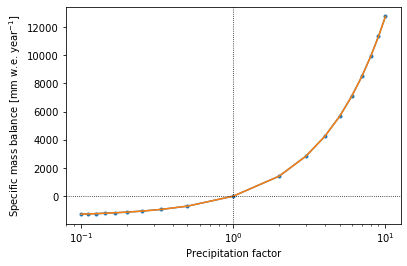

In [325]:
# create figure and axes
fig, ax = plt.subplots(1, 1)

#
ax.semilogx(const_mb, marker='.')
ax.plot(prcp_bias, lin_mod.coef_[0] * prcp_bias + lin_mod.intercept_)

# add aux lines
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.axvline(1, c='k', ls=':', lw=0.8)

# labels, title, ...
ax.set_xlabel('Precipitation factor')
ax.set_ylabel('Specific mass balance [mm w.e. year$^{-1}$]')

## Glacier evlution model
TODO:...

In [14]:
# model = vascaling.VAScalingModel()

## Random climate (mass balance) model
The `RandomVASMassBalance` model is a good tool to investigate/understand the model behavior. It takes climate information from a randomly chosen year within a 31-year period of a specified year `y0` to compute the specific mass balance. Hence, the model runs on a synthetic climate based on actual observations.

If we choose the climatological period around the "equilibrium" year $t^*$ the model glacier should stay in equilibirum. The `run_random_climate` task allows to add a temperature bias. Increasing/decresing the temperature of the equilibirum period should result in a retreating/advancing model glacier, which reaches a new equilibrium after some years.

In [15]:
# define number of years to run
nyears = 300
# get equilibrium year t* for HEF
t_star = gdir.read_json('vascaling_mustar')['t_star']
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, seed=12, output_filesuffix='_normal')
vascaling.run_random_climate(gdir, nyears=3000, y0=t_star, seed=12, output_filesuffix='_longtime')
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, temperature_bias=+0.5,
                             seed=12, output_filesuffix='_bias_p')
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, temperature_bias=-0.5,
                             seed=12, output_filesuffix='_bias_m');

2019-07-03 13:47:09: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_normal
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 13:47:10: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_longtime
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 13:47:12: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_bias_p
2019-07-03 13:47:13: oggm.core.vascaling: (RGI60-11.00897) run_random_climate_bias_m


Each task writes its output in a different file (specified by the suffix). To work with produced data, the output must be compiled (i.e., converted into a `xarray.dataset`). In this notebook we work only on a single glacier, however the `compile_run_output` task handels multiple glaciers (represented by `GlacierDirectorie`s at once).

In [16]:
def normalize_with_start(ds):
    """Normalize all data variables with their respecitve first entry.
    Retrurn a new xarray.dataset. """
    # copy the given dataset
    ds_ = ds.copy()
    # iterate over all data variables
    for var in ds_.data_vars:
        # normalize with start value
        ds_[var] = ds_[var]/ds_[var][0]
    # return normalized dataset
    return ds_

In [18]:
# compile the run output and normalize glacier geometries with start value
ds = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_normal'))
ds_longtime = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_longtime'))
ds_p = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_bias_p'))
ds_m = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_bias_m'))

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


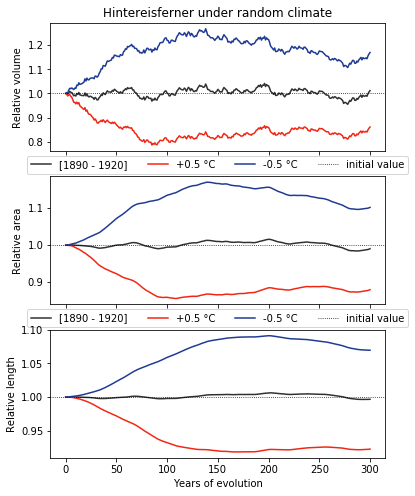

In [19]:
# create figure and axes
fig, [ax0, ax1, ax2] = plt.subplots(3,1, figsize=[6,8])
# plot the evolution of glacier volume
ax0.plot(ds.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax0.plot(ds_p.volume, label='+0.5 °C', c='#f22613')
ax0.plot(ds_m.volume, label='-0.5 °C', c='#1f3a93')
ax0.axhline(ds.volume[0], c='k', ls=':', lw=0.8, label='initial value')
ax0.set_xticklabels('')
ax0.set_ylabel('Relative volume')
ax0.set_title('Hintereisferner under random climate')
ax0.legend(bbox_to_anchor=(0.5, 0), loc=9, ncol=4)

# plot the evolution of glacier area
ax1.plot(ds.area, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax1.plot(ds_p.area, label='+0.5 °C', c='#f22613')
ax1.plot(ds_m.area, label='-0.5 °C', c='#1f3a93')
ax1.axhline(ds.area[0], c='k', ls=':', lw=0.8, label='initial value')
ax1.set_xticklabels('')
ax1.set_ylabel('Relative area')
ax1.legend(bbox_to_anchor=(0.5, 0), loc=9, ncol=4)

# plot the evolution of glacier length
ax2.plot(ds.length, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax2.plot(ds_p.length, label='+0.5 °C', c='#f22613')
ax2.plot(ds_m.length, label='-0.5 °C', c='#1f3a93')
ax2.axhline(ds.length[0], c='k', ls=':', lw=0.8, label='initial value')
ax2.set_xlabel('Years of evolution')
ax2.set_ylabel('Relative length')

fig.savefig('hef_random_climate.jpg', bbox_inches='tight')

## Compare with OGGM

In [20]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = utils.gettempdir('VAS_HEF_wdir')
if not os.path.exists(wdir):
    os.makedirs(wdir)
shutil.rmtree(wdir)
os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 100
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

2019-07-03 14:06:52: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [21]:
# read RGI entry for Hintereisferner as DataFrame
# containing the outline area as shapefile
entity = utils.get_rgi_glacier_entities([rgi_id]).iloc[0]
# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, reset=True)

In [22]:
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

2019-07-03 14:06:58: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-07-03 14:06:58: oggm.core.gis: (RGI60-11.00897) glacier_masks


In [23]:
# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-07-03 14:07:00: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-07-03 14:07:01: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-07-03 14:07:03: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2019-07-03 14:07:06: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2019-07-03 14:07:10: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2019-07-03 14:07:19: oggm.core.centerlines: (RGI60-11.00897) catchment_intersections
2019-07-03 14:07:20: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2019-07-03 14:07:29: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction


In [24]:
# compute the mass balance parameters for the OGGM model
climate.process_histalp_data(gdir)
climate.local_t_star(gdir)
climate.mu_star_calibration(gdir)

2019-07-03 14:07:29: oggm.core.climate: (RGI60-11.00897) process_histalp_data
2019-07-03 14:07:34: oggm.core.climate: (RGI60-11.00897) local_t_star
2019-07-03 14:07:34: oggm.core.climate: (RGI60-11.00897) local mu* computation for t*=1927
2019-07-03 14:07:35: oggm.core.climate: (RGI60-11.00897) mu_star_calibration


In [25]:
# run inversion tasks
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

2019-07-03 14:07:36: oggm.core.inversion: (RGI60-11.00897) prepare_for_inversion
2019-07-03 14:07:36: oggm.core.inversion: (RGI60-11.00897) mass_conservation_inversion
2019-07-03 14:07:36: oggm.core.inversion: (RGI60-11.00897) filter_inversion_output


In [26]:
# final task
flowline.init_present_time_glacier(gdir)

2019-07-03 14:07:36: oggm.core.flowline: (RGI60-11.00897) init_present_time_glacier


In [ ]:
# define number of years to run
nyears = 300
# get equilibrium year t* for HEF
t_star_oggm = gdir.read_json('local_mustar')['t_star']
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, seed=12, output_filesuffix='_oggm')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=+0.5,
                             seed=12, output_filesuffix='_oggm_bias_p')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=-0.5,
                             seed=12, output_filesuffix='_oggm_bias_m');

2019-07-03 15:16:31: oggm.core.flowline: (RGI60-11.00897) run_random_climate_oggm
2019-07-03 15:16:33: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [32]:
# define number of years to run
nyears = 300
# get equilibrium year t* for HEF
t_star_oggm = gdir.read_json('local_mustar')['t_star']
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = True
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, seed=12, output_filesuffix='_oggm_mbbias')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=+0.5,
                             seed=12, output_filesuffix='_oggm_mbbias_bias_p')
flowline.run_random_climate(gdir, nyears=nyears, y0=t_star_oggm, temperature_bias=-0.5,
                             seed=12, output_filesuffix='_oggm_mbbias_bias_m');

2019-07-03 15:16:31: oggm.core.flowline: (RGI60-11.00897) run_random_climate_oggm
2019-07-03 15:16:33: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 15:18:24: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2019-07-03 15:18:24: oggm.core.flowline: (RGI60-11.00897) run_random_climate_oggm_bias_p
2019-07-03 15:18:25: oggm.core.flowline: (RGI60-11.00897) trying default time stepping scheme.
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 15:20:25: oggm.core.flowline: (RGI60-11.00897) default time stepping was successful!
2019-07-03 

KeyboardInterrupt: 

In [ ]:
ds_oggm = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm'))
ds_oggm_p = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_bias_p'))
ds_oggm_m = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_bias_m'))

In [ ]:
ds_oggm_mbbias = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_mbbias'))
ds_oggm_mbbias_p = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_mbbias_bias_p'))
ds_oggm_mbbias_m = normalize_with_start(utils.compile_run_output([gdir], filesuffix='_oggm_mbbias_bias_m'))

In [ ]:
# create figure and axes
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=[6,8])
# plot the evolution of glacier volume
ax0.plot(ds.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#2e3131')
ax0.plot(ds_p.volume, label='+0.5 °C', c='#f22613')
ax0.plot(ds_m.volume, label='-0.5 °C', c='#1f3a93')
ax0.axhline(ds.volume[0], c='k', ls=':', lw=0.8, label='initial volume')
ax0.set_ylabel('Relative volume')
ax0.set_title('Volume/Area scaling model')
ax0.legend()
ax1.plot(ds_oggm.volume, label='[{} - {}]'.format(t_star_oggm-15, t_star_oggm+15), c='#6c7a89')
ax1.plot(ds_oggm_p.volume, label='+0.5 °C', c='#f89406')
ax1.plot(ds_oggm_m.volume, label='-0.5 °C', c='#2c82c9')
ax1.axhline(ds_oggm.volume[0], c='k', ls=':', lw=0.8, label='initial volume')
ax1.set_ylabel('Volume [km$^3$]')
ax1.set_title('Relative volume')
ax1.legend()

fig.savefig('vas_oggm_random.pdf', bbox_inches='tight')

In [ ]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1, figsize=[8,4])

# plot normalized vas volume
ax0.plot(ds.volume, label='[{} - {}]'.format(t_star-15, t_star+15), c='#1f3a93', lw=2)
ax0.plot(ds_p.volume, label='+0.5 °C', c='#4d13d1', lw=2)
ax0.plot(ds_m.volume, label='-0.5 °C', c='#19b5fe', lw=2)

# add aux line at 1
ax0.axhline(ds.volume[0], c='k', ls=':', lw=0.8)

# plot normalized oggm volume
ax0.plot(ds_oggm.volume, label='[{} - {}]'.format(t_star_oggm-15, t_star_oggm+15), c='#d35400', ls='-.', lw=1.5)
ax0.plot(ds_oggm_p.volume, label='+0.5 °C', c='#cf000f', ls='-.', lw=1.5)
ax0.plot(ds_oggm_m.volume, label='-0.5 °C', c='#fcd670', ls='-.', lw=1.5)

# add legend(s)
handels, labels = ax0.get_legend_handles_labels()
l_vas = ax0.legend(handels[:3], labels[:3], title='VAS model', bbox_to_anchor=(1, 1), loc=2)
l_vas.get_title().set_fontweight('bold')
l_oggm = ax0.legend(handels[3:], labels[3:], title='OGGM', bbox_to_anchor=(1, 0), loc=3)
l_oggm.get_title().set_fontweight('bold')
ax0.add_artist(l_vas)

# title, labels, ...
ax0.set_title('Evolution of HEF volume under random (equilibrium) climate')
ax0.set_xlabel('Years of evolution')
ax0.set_ylabel('Relative glacier volume')

# store to file
fig.savefig('vas_oggm_random_oneplot.jpg', bbox_inches='tight')

In [ ]:
# create figure and axes
fig, ax0 = plt.subplots(1, 1, figsize=[8,4])

# plot normalized vas length
ax0.plot(ds.length, label='[{} - {}]'.format(t_star-15, t_star+15), c='#1f3a93', lw=2)
ax0.plot(ds_p.length, label='+0.5 °C', c='#4d13d1', lw=2)
ax0.plot(ds_m.length, label='-0.5 °C', c='#19b5fe', lw=2)

# add aux line at 1
ax0.axhline(ds.length[0], c='k', ls=':', lw=0.8)

# plot normalized oggm length
ax0.plot(ds_oggm.length, label='[{} - {}]'.format(t_star_oggm-15, t_star_oggm+15), c='#d35400', ls='-.', lw=1.5)
ax0.plot(ds_oggm_p.length, label='+0.5 °C', c='#cf000f', ls='-.', lw=1.5)
ax0.plot(ds_oggm_m.length, label='-0.5 °C', c='#fcd670', ls='-.', lw=1.5)

# add legend(s)
handels, labels = ax0.get_legend_handles_labels()
l_vas = ax0.legend(handels[:3], labels[:3], title='VAS model', bbox_to_anchor=(1, 1), loc=2)
l_vas.get_title().set_fontweight('bold')
l_oggm = ax0.legend(handels[3:], labels[3:], title='OGGM', bbox_to_anchor=(1, 0), loc=3)
l_oggm.get_title().set_fontweight('bold')
ax0.add_artist(l_vas)

# title, labels, ...
ax0.set_title('Evolution of HEF length under random (equilibrium) climate')
ax0.set_xlabel('Years of evolution')
ax0.set_ylabel('Relative glacier length')

# store to file
fig.savefig('vas_oggm_random_oneplot.jpg', bbox_inches='tight')

### Power spectrum

In [ ]:
# load module for the spectral analysis
from scipy import signal

In [ ]:
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False
# run RandomMassBalance model centered around t*, once without tempertaure bias
# and once with positive and negitave temperature bias of 0.5 °C each.
flowline.run_random_climate(gdir, nyears=3000, y0=t_star_oggm, seed=12, output_filesuffix='_oggm')

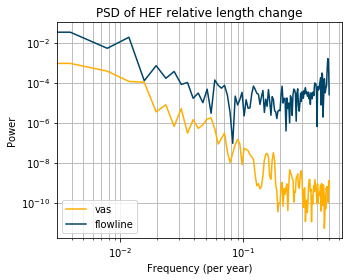

In [498]:
# visualize the results
plt.figure(figsize=(5, 4))

# compute the power of the signel per frequency band
sig = ds_lo.length.values.flatten()
freqs, psd = signal.welch(sig)
plt.loglog(freqs, psd, label='vas', c='#FFAE03')

# compute the power of the signel per frequency band
sig = ds_oggm.length.values.flatten()
freqs, psd = signal.welch(sig)
plt.loglog(freqs, psd, label='flowline', c='#004468')

plt.title('PSD of HEF relative length change')
plt.xlabel('Frequency (per year)')
plt.ylabel('Power')
plt.tight_layout()
plt.grid(which='both')
plt.legend()

## Finding a historic start area
TODO...

In [27]:
res = vascaling.find_start_area(gdir, year_start=t_star)
res

2019-06-25 16:58:44: oggm.core.vascaling: (RGI60-11.00897) find_start_area
2019-06-25 16:58:44: oggm.core.vascaling: FileNotFoundError occurred during task find_start_area on RGI60-11.00897: [Errno 2] No such file or directory: '/var/folders/dc/r0qdkr9n45n4c2f2cc7v7pfr0000gn/T/OGGM/VAS_HEF_wdir/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/vascaling_mustar.json'


FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/dc/r0qdkr9n45n4c2f2cc7v7pfr0000gn/T/OGGM/VAS_HEF_wdir/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/vascaling_mustar.json'

In [ ]:
vascaling.run_random_climate(gdir, nyears=nyears, y0=t_star, seed=12, init_area_m2=res.x, output_filesuffix='_init')

In [ ]:
ds_init = utils.compile_run_output([gdir], filesuffix='_init')

In [ ]:
ax = plt.subplot(1,1,1)
ax.plot(ds.area, label='')
ax.plot(ds_init.area)

In [ ]:
ds.volume.plot()